In [1]:
# !pip install tensorflow_datasets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatbotData.csv")

('ChatbotData.csv', <http.client.HTTPMessage at 0x1a17ac0cdd8>)

In [4]:
train_data = pd.read_csv('chatbotData.csv')
train_data[:4]

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0


In [5]:
len(train_data)

11823

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [7]:
train_data.isna().sum()

Q        0
A        0
label    0
dtype: int64

In [8]:
# 띄어쓰기를 추가하여 문장 구분
bots = []
for sentence in train_data['Q']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence).strip()
    bots.append(sentence)
users = []
for sentence in train_data['A']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence).strip()
    users.append(sentence)

In [9]:
print(bots[:5])
print(users[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


In [10]:
# 서브워드텍스트인코더를 사용하여 질문, 답변 데이터로부터 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    bots + users,
    target_vocab_size=2**13 # 2**13: 2의 13승
)

In [11]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [12]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8178]
종료 토큰 번호 : [8179]
단어 집합의 크기 : 8180


In [13]:
# 정수 인코딩
print('15번째 질문 샘플을 정수 인코딩 : ', tokenizer.encode(bots[15]))

15번째 질문 샘플을 정수 인코딩 :  [78, 62, 1146, 5487, 1574]


In [14]:
MAX_LENGTH = 40 # 최대 길이 지정

In [15]:
# 토큰화 + 정수 인코딩 --> 시작 토큰과 종료 토큰 추가 --> 패딩
def preprocessing(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)

    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [16]:
bots, users = preprocessing(bots, users)

In [17]:
print('질문: ', bots.shape, '답변: ', users.shape)

질문:  (11823, 40) 답변:  (11823, 40)


In [18]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': bots,
        'dec_inputs': users[:, :-1] # 마지막 패딩 토큰 제거
    },
    {
        'outputs': users[:, 1:]  # 시작 토큰 제거
    },
))

In [20]:
dataset = dataset.cache() # 캐싱
dataset = dataset.batch(BATCH_SIZE) # 배치 크기로 데이터를 묶음
dataset = dataset.shuffle(BUFFER_SIZE) # 버퍼 크기로 셔플 수행
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) # 실제값 오토튠

In [21]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

    # 인코더의 입력
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 디코더의 입력
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더의 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

    # 디코더의 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

    # 디코더의 패딩 마스크(두번째 서브층)
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
    )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 다음 단어 예측을 위한 출력층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [22]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])

        # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        print(pos_encoding.shape)
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [23]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, key의 문장 길이)
    return mask[:, tf.newaxis, tf.newaxis, :]

# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
    return tf.maximum(look_ahead_mask, padding_mask)

#encoder
def encoder(vocab_size, num_layers, dff,
        d_model, num_heads, dropout,
        name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 인코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
            dropout=dropout, name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [24]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [25]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        # d_model을 num_heads로 나눈 값.
        # 논문 기준 : 64
        self.depth = d_model // self.num_heads

        # WQ, WK, WV에 해당하는 밀집층 정의
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        # WO에 해당하는 밀집층 정의
        self.dense = tf.keras.layers.Dense(units=d_model)
    
    def get_config(self):
        config = {
        'd_model': self.d_model,
        'warmup_steps': self.warmup_steps,

        }
        return config
    
    # num_heads 개수만큼 q, k, v를 split하는 함수
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2. 헤드 나누기
        # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
        # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
        # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 4. 헤드 연결(concatenate)하기
        # (batch_size, query의 문장 길이, d_model)
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 5. WO에 해당하는 밀집층 지나기
        # (batch_size, query의 문장 길이, d_model)
        outputs = self.dense(concat_attention)

        return outputs

In [26]:
def scaled_dot_product_attention(query, key, value, mask):
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding_mask : (batch_size, 1, 1, key의 문장 길이)

    # Q와 K의 곱. 어텐션 스코어 행렬.
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 스케일링
    # dk의 루트값으로 나눠준다.
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
    if mask is not None:
        logits += (mask * -1e9)

    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    output = tf.matmul(attention_weights, value)

    return output, attention_weights

In [27]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

    # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 디코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
            dropout=dropout, name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [28]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

    # 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

    # 패딩 마스크(두번째 서브층)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

    # 잔차 연결과 층 정규화
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [29]:
tf.keras.backend.clear_session()

# 하이퍼파라미터 --> 모델 설계 시 사용자가 임의로 변경할 수 있는 값들
# 트랜스포머의 인코더와 디코더에서의 정해진 입력과 출력의 크기
D_MODEL = 256
# 트랜스포머 모델에서 인코더와 디코더가 총 몇 층으로 구성되었는지
NUM_LAYERS = 2
# 어텐션 사용 시 여러 개로 분할해서 병렬로 수행하고 결과값을 합칠 때의 병렬의 개수
NUM_HEADS = 8
# 트랜스포머 내부의 피드 포워드 신경망의 은닉층 크기
DFF = 512
DROPOUT = 0.1

In [30]:
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(1, 8180, 256)
(1, 8180, 256)


In [31]:
from IPython.display import Image

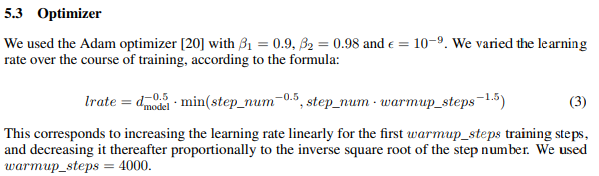

In [32]:
Image('./image/사용자 정의 학습률 스케쥴러 적용 옵티마이저 공식.png')

In [33]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [34]:
# 학습률 정의
learning_rate = CustomSchedule(D_MODEL)
# 사용자 정의 학습률(learning rate) 스케줄러를 적용한 아담(Adam) 옵티마이저
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [35]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [36]:
def accuracy(y_true, y_pred):
    # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [37]:
cp = ModelCheckpoint('daily_conversation_model.h5', save_best_only=True)

In [38]:
model.fit(dataset, epochs=50, callbacks=[cp])

Epoch 1/50
185/185 [==============================] - ETA: 0s - loss: 1.4610 - accuracy: 0.0253WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 111s 576ms/step - loss: 1.4610 - accuracy: 0.0253
Epoch 2/50
185/185 [==============================] - ETA: 0s - loss: 1.1892 - accuracy: 0.0494WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 108s 583ms/step - loss: 1.1892 - accuracy: 0.0494
Epoch 3/50
185/185 [==============================] - ETA: 0s - loss: 1.0127 - accuracy: 0.0502WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 105s 570ms/step - loss: 1.0127 - accuracy: 0.0502
Epoch 4/50
185/185 [==============================] - ETA: 0s - loss: 0.9437 - accuracy: 0.0533WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 109s 587ms/step - loss: 0.9437 - accuracy: 0.0533
Epoch 5/50
185/185 [==============================] - ETA: 0s - loss: 0.8913 - accuracy: 0.0563WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 104s 563ms/step - loss: 0.8913 - accuracy: 0.0563
Epoch 6/50
185/185 [==============================] - ETA: 0s - loss: 0.8376 - accuracy: 0.0597WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 108s 582ms/step - loss: 0.8376 - accuracy: 0.0597
Epoch 7/50
185/185 [==============================] - ETA: 0s - loss: 0.7773 - accuracy: 0.0645WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 99s 536ms/step - loss: 0.7773 - accuracy: 0.0645
Epoch 8/50
185/185 [==============================] - ETA: 0s - loss: 0.7131 - accuracy: 0.0709WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 98s 528ms/step - loss: 0.7131 - accuracy: 0.0709
Epoch 9/50
185/185 [==============================] - ETA: 0s - loss: 0.6419 - accuracy: 0.0783WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 98s 528ms/step - loss: 0.6419 - accuracy: 0.0783
Epoch 10/50
185/185 [==============================] - ETA: 0s - loss: 0.5669 - accuracy: 0.0865WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 98s 532ms/step - loss: 0.5669 - accuracy: 0.0865
Epoch 11/50
185/185 [==============================] - ETA: 0s - loss: 0.4895 - accuracy: 0.0951WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 102s 549ms/step - loss: 0.4895 - accuracy: 0.0951
Epoch 12/50
185/185 [==============================] - ETA: 0s - loss: 0.4108 - accuracy: 0.1050WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 98s 530ms/step - loss: 0.4108 - accuracy: 0.1050
Epoch 13/50
185/185 [==============================] - ETA: 0s - loss: 0.3348 - accuracy: 0.1154WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 97s 522ms/step - loss: 0.3348 - accuracy: 0.1154
Epoch 14/50
185/185 [==============================] - ETA: 0s - loss: 0.2643 - accuracy: 0.1259WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 97s 523ms/step - loss: 0.2643 - accuracy: 0.1259
Epoch 15/50
185/185 [==============================] - ETA: 0s - loss: 0.2011 - accuracy: 0.1365WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 97s 522ms/step - loss: 0.2011 - accuracy: 0.1365
Epoch 16/50
185/185 [==============================] - ETA: 0s - loss: 0.1497 - accuracy: 0.1454WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 96s 521ms/step - loss: 0.1497 - accuracy: 0.1454
Epoch 17/50
185/185 [==============================] - ETA: 0s - loss: 0.1100 - accuracy: 0.1528WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 97s 523ms/step - loss: 0.1100 - accuracy: 0.1528
Epoch 18/50
185/185 [==============================] - ETA: 0s - loss: 0.0837 - accuracy: 0.1575WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 96s 521ms/step - loss: 0.0837 - accuracy: 0.1575
Epoch 19/50
185/185 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.1612WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 97s 525ms/step - loss: 0.0641 - accuracy: 0.1612
Epoch 20/50
185/185 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.1622WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 97s 522ms/step - loss: 0.0563 - accuracy: 0.1622
Epoch 21/50
185/185 [==============================] - ETA: 0s - loss: 0.0492 - accuracy: 0.1636WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 97s 523ms/step - loss: 0.0492 - accuracy: 0.1636
Epoch 22/50
185/185 [==============================] - ETA: 0s - loss: 0.0473 - accuracy: 0.1636WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 97s 522ms/step - loss: 0.0473 - accuracy: 0.1636
Epoch 23/50
185/185 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.1650WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 97s 523ms/step - loss: 0.0418 - accuracy: 0.1650
Epoch 24/50
185/185 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.1665WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 97s 522ms/step - loss: 0.0358 - accuracy: 0.1665
Epoch 25/50
185/185 [==============================] - ETA: 0s - loss: 0.0310 - accuracy: 0.1676WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 98s 528ms/step - loss: 0.0310 - accuracy: 0.1676
Epoch 26/50
185/185 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.1685WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 97s 527ms/step - loss: 0.0269 - accuracy: 0.1685
Epoch 27/50
185/185 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 0.1689WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 100s 542ms/step - loss: 0.0254 - accuracy: 0.1689
Epoch 28/50
185/185 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.1696WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 97s 526ms/step - loss: 0.0221 - accuracy: 0.1696
Epoch 29/50
185/185 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.1703WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 99s 535ms/step - loss: 0.0200 - accuracy: 0.1703
Epoch 30/50
185/185 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.1706WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 107s 579ms/step - loss: 0.0184 - accuracy: 0.1706
Epoch 31/50
185/185 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.1710WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 104s 561ms/step - loss: 0.0166 - accuracy: 0.1710
Epoch 32/50
185/185 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.1715WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 98s 532ms/step - loss: 0.0151 - accuracy: 0.1715
Epoch 33/50
185/185 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.1716WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 97s 524ms/step - loss: 0.0143 - accuracy: 0.1716
Epoch 34/50
185/185 [==============================] - ETA: 0s - loss: 0.0132 - accuracy: 0.1719WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 98s 528ms/step - loss: 0.0132 - accuracy: 0.1719
Epoch 35/50
185/185 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.1721WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 102s 553ms/step - loss: 0.0124 - accuracy: 0.1721
Epoch 36/50
185/185 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.1723WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 105s 567ms/step - loss: 0.0120 - accuracy: 0.1723
Epoch 37/50
185/185 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.1726WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 127s 684ms/step - loss: 0.0106 - accuracy: 0.1726
Epoch 38/50
185/185 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.1726WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 100s 538ms/step - loss: 0.0105 - accuracy: 0.1726
Epoch 39/50
185/185 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.1729WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 105s 567ms/step - loss: 0.0094 - accuracy: 0.1729
Epoch 40/50
185/185 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.1728WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 107s 576ms/step - loss: 0.0095 - accuracy: 0.1728
Epoch 41/50
185/185 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 0.1730WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 102s 552ms/step - loss: 0.0087 - accuracy: 0.1730
Epoch 42/50
185/185 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.1731WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 98s 529ms/step - loss: 0.0082 - accuracy: 0.1731
Epoch 43/50
185/185 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.1732WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 98s 529ms/step - loss: 0.0078 - accuracy: 0.1732
Epoch 44/50
185/185 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 0.1733WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 99s 535ms/step - loss: 0.0074 - accuracy: 0.1733
Epoch 45/50
185/185 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 0.1733WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 99s 536ms/step - loss: 0.0075 - accuracy: 0.1733
Epoch 46/50
185/185 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.1733WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 98s 530ms/step - loss: 0.0073 - accuracy: 0.1733
Epoch 47/50
185/185 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 0.1736WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 98s 530ms/step - loss: 0.0065 - accuracy: 0.1736
Epoch 48/50
185/185 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 0.1735WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 101s 547ms/step - loss: 0.0065 - accuracy: 0.1735
Epoch 49/50
185/185 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.1737WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 101s 543ms/step - loss: 0.0062 - accuracy: 0.1737
Epoch 50/50
185/185 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.1737WARNING:tensorflow:Can save best model only with val_loss available, skipping.


185/185 [==============================] - 110s 595ms/step - loss: 0.0060 - accuracy: 0.1737


In [39]:
def preprocess_predsentence(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    return sentence

In [40]:
def evaluate(sentence):
    # 입력 문장에 대한 전처리
    sentence = preprocess_predsentence(sentence)

    # 입력 문장에 시작 토큰과 종료 토큰을 추가
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    output = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 예측 시작
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

        # 현재 시점의 예측 단어를 받아온다.
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 시점의 예측 단어가 종료 토큰이라면 예측을 중단
        if tf.equal(predicted_id, END_TOKEN[0]):
              break

        # 현재 시점의 예측 단어를 output(출력)에 연결한다.
        # output은 for문의 다음 루프에서 디코더의 입력이 된다.
        output = tf.concat([output, predicted_id], axis=-1)

    # 단어 예측이 모두 끝났다면 output을 리턴.
    return tf.squeeze(output, axis=0)

In [41]:
def predict(sentence):
    prediction = evaluate(sentence)

    # prediction == 디코더가 리턴한 챗봇의 대답에 해당하는 정수 시퀀스
    # tokenizer.decode()를 통해 정수 시퀀스를 문자열로 디코딩.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))

    return predicted_sentence

In [42]:
chatbot_sentence = predict("12시 땡!")

Input: 12시 땡!
Output: 하루가 또 가네요 .


In [51]:
type(model)

keras.engine.functional.Functional

In [52]:
from tensorflow.keras.utils import plot_model

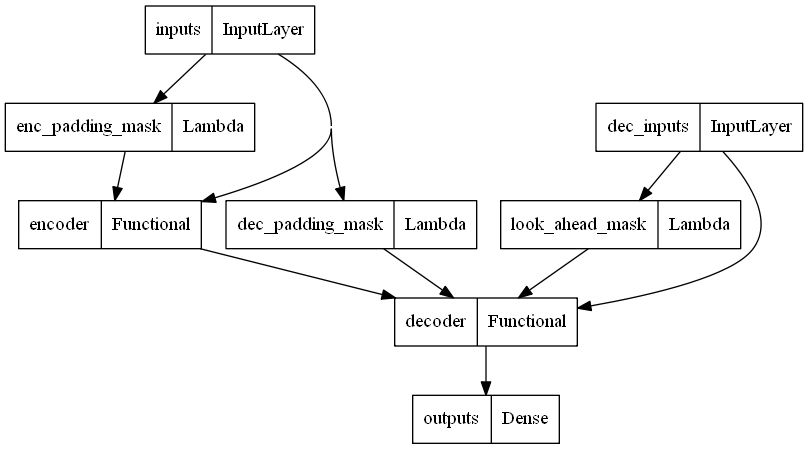

In [53]:
plot_model(model)

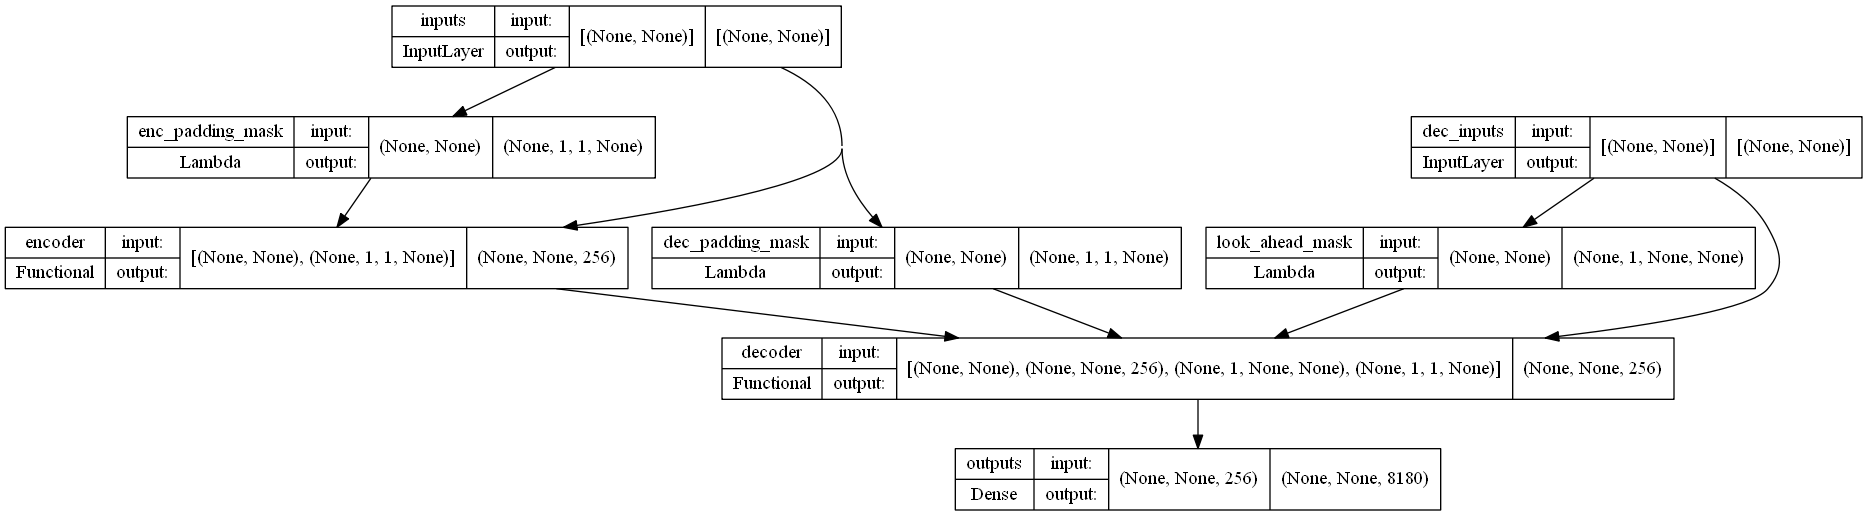

In [55]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [56]:
model.save("daily_conversation_model")

INFO:tensorflow:Assets written to: daily_conversation_model\assets


INFO:tensorflow:Assets written to: daily_conversation_model\assets


NotImplementedError: Learning rate schedule must override get_config